In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
import xarray as xr
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [4]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

ppt_prods = ['chirps','cpc','imerg','prism']
tws_prods = ['grace-csr','grace-jpl','clsm-grace']

prod_comb = []
for p in ppt_prods:
    for t in tws_prods:
        prod_comb.append(f"{p}_{t}")
fema_dict = {p:pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',p,'county_se','fema.csv')).set_index("Coefficient") for p in prod_comb}
flopro_dict = {p:pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',p,'county_se','flopro.csv')).set_index("Coefficient") for p in prod_comb}


In [5]:
fp = np.linspace(-665,1123,100)
fema_nodd_me0 = {p:fema_coef.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(fema_coef.loc['p_exc_rxmon_sq'],fp) for p,fema_coef in fema_dict.items()}
fema_dd_me0 = {p:fema_coef.loc['p_exc_rxmon:C(flood_decl_incltc)[T.1.0]'].values.reshape(-1,1)+2*np.outer(fema_coef.loc['p_exc_rxmon_sq:C(flood_decl_incltc)[T.1.0]'],fp) for p,fema_coef in fema_dict.items()}

fema_nodd_me1 = {p:fema_coef.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(fema_coef.loc['p_exc_rxmon_sq_lag1'],fp) for p,fema_coef in fema_dict.items()}
fema_dd_me1 = {p:fema_coef.loc['p_exc_rxmon_lag1:C(flood_decl_incltc_lag1)[T.1.0]'].values.reshape(-1,1)+2*np.outer(fema_coef.loc['p_exc_rxmon_sq_lag1:C(flood_decl_incltc_lag1)[T.1.0]'],fp) for p,fema_coef in fema_dict.items()}

fema_dd_me1 = {p:fema_nodd_me0[p]+fema_dd_me0[p]+fema_nodd_me1[p]+fema_dd_me1[p] for p in fema_dd_me1.keys()}
fema_nodd_me1 = {p:fema_nodd_me0[p]+fema_nodd_me1[p] for p in fema_nodd_me1.keys()}
fema_dd_me0 = {p:fema_nodd_me0[p]+fema_dd_me0[p] for p in fema_dd_me0.keys()}

fema_nodd_me0_all = np.concatenate(list(fema_nodd_me0.values()),axis=0)
fema_nodd_me1_all = np.concatenate(list(fema_nodd_me1.values()),axis=0)

fema_dd_me0_all = np.concatenate(list(fema_dd_me0.values()),axis=0)
fema_dd_me1_all = np.concatenate(list(fema_dd_me1.values()),axis=0)


In [6]:
no_flopro_me0 = {p:flopro_coef.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(flopro_coef.loc['p_exc_rxmon_sq'],fp) for p,flopro_coef in flopro_dict.items()}
flopro_me0 = {p:flopro_coef.loc['p_exc_rxmon:C(flopro)[T.True]'].values.reshape(-1,1)+2*np.outer(flopro_coef.loc['p_exc_rxmon_sq:C(flopro)[T.True]'],fp) for p,flopro_coef in flopro_dict.items()}

no_flopro_me1 = {p:flopro_coef.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(flopro_coef.loc['p_exc_rxmon_sq_lag1'],fp) for p,flopro_coef in flopro_dict.items()}
flopro_me1 = {p:flopro_coef.loc['p_exc_rxmon_lag1:C(flopro)[T.True]'].values.reshape(-1,1)+2*np.outer(flopro_coef.loc['p_exc_rxmon_sq_lag1:C(flopro)[T.True]'],fp) for p,flopro_coef in flopro_dict.items()}

flopro_me1 = {p:flopro_me1[p]+no_flopro_me1[p]+flopro_me0[p]+no_flopro_me0[p] for p in flopro_me1.keys()}
no_flopro_me1 = {p:no_flopro_me1[p]+no_flopro_me0[p] for p in no_flopro_me1.keys()}
flopro_me0 = {p:no_flopro_me0[p]+flopro_me0[p] for p in flopro_me0.keys()}

no_flopro_me0_all = np.concatenate(list(no_flopro_me0.values()),axis=0)
flopro_me0_all = np.concatenate(list(flopro_me0.values()),axis=0)

no_flopro_me1_all = np.concatenate(list(no_flopro_me1.values()),axis=0)
flopro_me1_all = np.concatenate(list(flopro_me1.values()),axis=0)

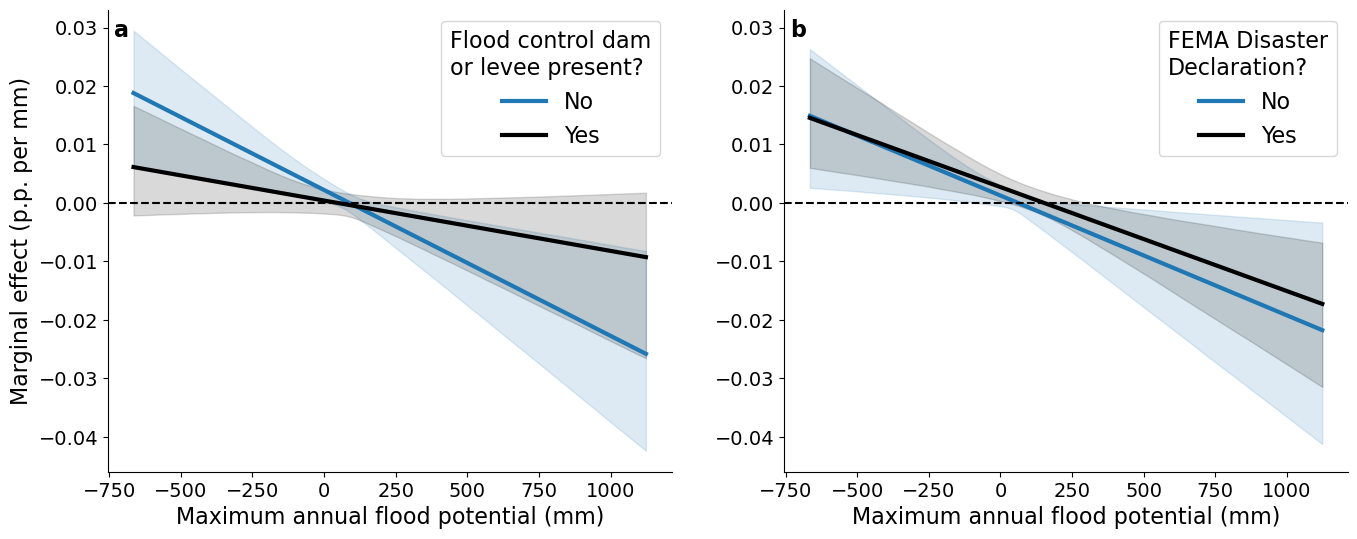

In [7]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(nrows=1,ncols=2,figure=fig)
ax1 = plt.subplot(gs[0])
ax1.plot(fp,no_flopro_me0_all.mean(axis=0),color='tab:blue',lw=3,label='No')
ax1.fill_between(fp,
                 np.quantile(no_flopro_me0_all,0.025,axis=0),
                 np.quantile(no_flopro_me0_all,0.975,axis=0),
                 color='tab:blue',alpha=0.15)

ax1.plot(fp,flopro_me0_all.mean(axis=0),color='black',lw=3,label='Yes')
ax1.fill_between(fp,
                 np.quantile(flopro_me0_all,0.025,axis=0),
                 np.quantile(flopro_me0_all,0.975,axis=0),
                 color='black',alpha=0.15)
ax1.axhline(0,color='black',linestyle='--')
ax1.legend(title='Flood control dam\nor levee present?')
ax1.set_xlabel("Maximum annual flood potential (mm)")
ax1.set_ylabel("Marginal effect (p.p. per mm)")

ax2 = plt.subplot(gs[1],sharey=ax1)
ax2.plot(fp,fema_nodd_me0_all.mean(axis=0),color='tab:blue',lw=3,label='No')
ax2.fill_between(fp,
                 np.quantile(fema_nodd_me0_all,0.025,axis=0),
                 np.quantile(fema_nodd_me0_all,0.975,axis=0),
                 color='tab:blue',alpha=0.15)

ax2.plot(fp,fema_dd_me0_all.mean(axis=0),color='black',lw=3,label='Yes')
ax2.fill_between(fp,
                 np.quantile(fema_dd_me0_all,0.025,axis=0),
                 np.quantile(fema_dd_me0_all,0.975,axis=0),
                 color='black',alpha=0.15)
ax2.axhline(0,color='black',linestyle='--')
ax2.legend(title='FEMA Disaster\nDeclaration?')
ax2.set_xlabel("Maximum annual flood potential (mm)")
ax2.set_ylabel("")
labels = ['a','b',]
for i,ax in enumerate([ax1,ax2,]):
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.savefig(os.path.join(project_dir,'figures','supp_mat','adaptation.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','adaptation.pdf'),bbox_inches='tight',dpi=350)
plt.show()